<a href="https://colab.research.google.com/github/Yashmaini30/Breast-Cancer-Detection/blob/main/ResNet50_on_Breast_Cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from __future__ import absolute_import, print_function, division, unicode_literals
import os
import glob
import shutil
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, Activation, GlobalAveragePooling2D
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

!pip install imagehash
import imagehash

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.9 MB/s eta 0:00:00


In [2]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = "/content/drive/MyDrive/archive"
data_dir = pathlib.Path(data_dir)

In [3]:
train_path = data_dir / 'train'
test_path = data_dir / 'test'

In [ ]:
# Remove Duplicates
def remove_duplicates(image_folder):
    image_hashes = {}
    duplicates = []
    for img_path in glob.glob(f'{image_folder}/**/*.png', recursive=True):
        try:
            img = Image.open(img_path)
            img_hash = imagehash.phash(img)
            if img_hash in image_hashes:
                duplicates.append(img_path)
            else:
                image_hashes[img_hash] = img_path
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    for dup in duplicates:
        os.remove(dup)
    print(f'Removed {len(duplicates)} duplicates.')


remove_duplicates(train_path)
remove_duplicates(test_path)

Removed 185 duplicates.
Removed 37 duplicates.


In [5]:
categories = os.listdir(train_path)

nums = {}
for label in categories:
    nums[label] = len(os.listdir(train_path / label))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
normal,106
malignant,334
benign,635


In [6]:
image_train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.70,
    rotation_range=60,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.20,
    height_shift_range=0.20
)
train_data_gen = image_train_gen.flow_from_directory(
    train_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

Found 1075 images belonging to 3 classes.


In [7]:
img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(
    test_path,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)


Found 281 images belonging to 3 classes.


Training dataset:


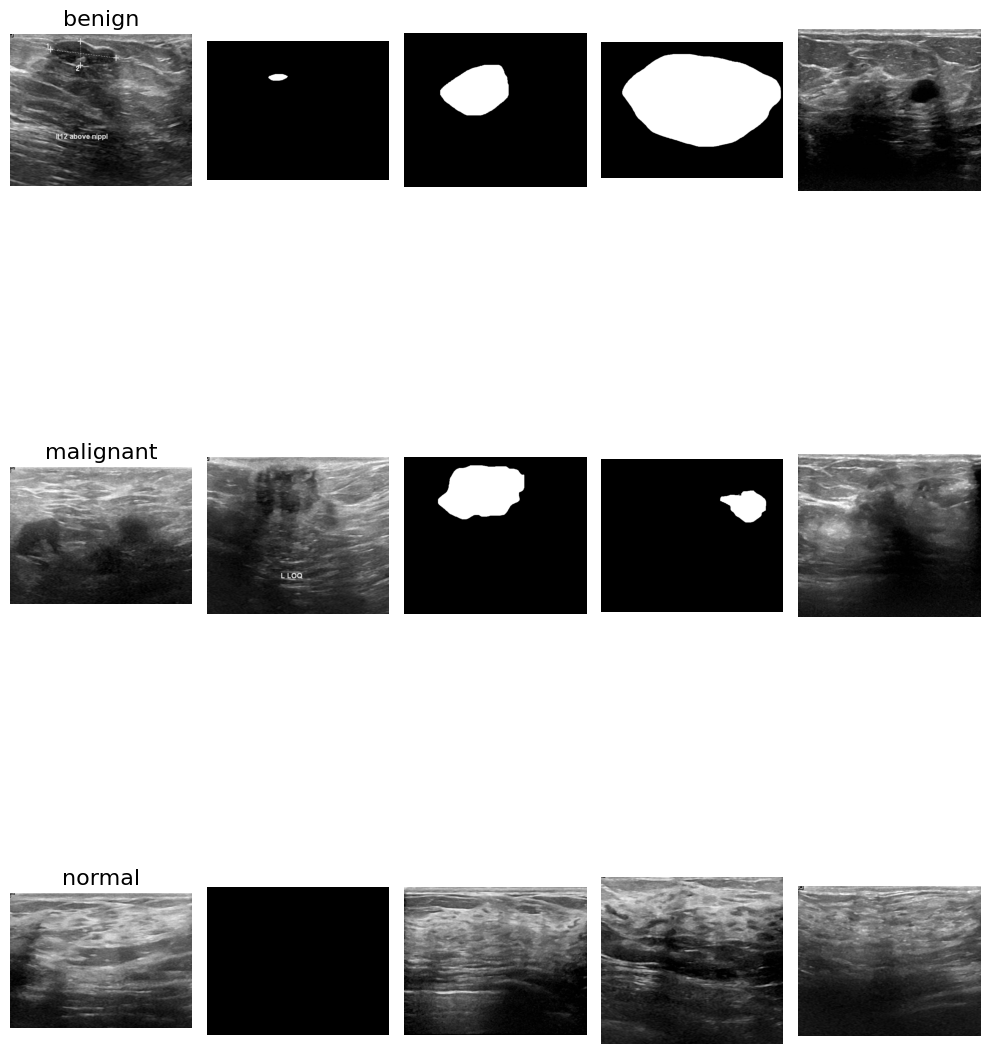

In [10]:
def display_class_images(image_folder, class_names, num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(10, 5 * len(class_names)))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(image_folder, class_name)
        image_paths = glob.glob(f'{class_path}/*.png')[:num_images]

        for j, img_path in enumerate(image_paths):
            img = Image.open(img_path)
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, size=16)

    plt.tight_layout()
    plt.show()


class_names = ['benign', 'malignant', 'normal']


print("Training dataset:")
display_class_images(train_path, class_names)



In [11]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                      include_top=False,
                      weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Increased dropout rate
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 4,728,323 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [16]:
# Learning rate scheduling
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [17]:
EPOCHS = 20
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[lr_schedule]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 652s 5s/step - accuracy: 0.4736 - loss: 3.5509 - val_accuracy: 0.6299 - val_loss: 3.2320 - learning_rate: 1.0000e-05
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.5425 - loss: 3.4678 - val_accuracy: 0.7117 - val_loss: 3.1255 - learning_rate: 1.0000e-05
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.4985 - loss: 3.3891 - val_accuracy: 0.7295 - val_loss: 3.0098 - learning_rate: 1.0000e-05
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.5321 - loss: 3.3374 - val_accuracy: 0.7331 - val_loss: 2.9557 - learning_rate: 1.0000e-05
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.5706 - loss: 3.2588 - val_accuracy: 0.7331 - val_loss: 2.9157 - learning_rate: 1.0000e-05
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.5870 - loss: 3.1391 - val_accuracy: 0.7367 - val_loss: 2.8691 - learning_rate: 1.0000e-05
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.56

In [18]:
val_loss, val_acc = model.evaluate(val_data_gen)
print("Validation Accuracy: ", val_acc)

36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7428 - loss: 2.4035
Validation Accuracy:  0.7473309636116028


In [26]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix: \n", conf_matrix)


Accuracy:  0.5693950177935944
Precision:  0.4725790585307989
Recall:  0.5693950177935944
              precision    recall  f1-score   support

      normal       0.62      0.85      0.71       175
      benign       0.29      0.14      0.19        85
   malignant       0.00      0.00      0.00        21

    accuracy                           0.57       281
   macro avg       0.30      0.33      0.30       281
weighted avg       0.47      0.57      0.50       281

Confusion Matrix: 
 [[148  27   0]
 [ 73  12   0]
 [ 19   2   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

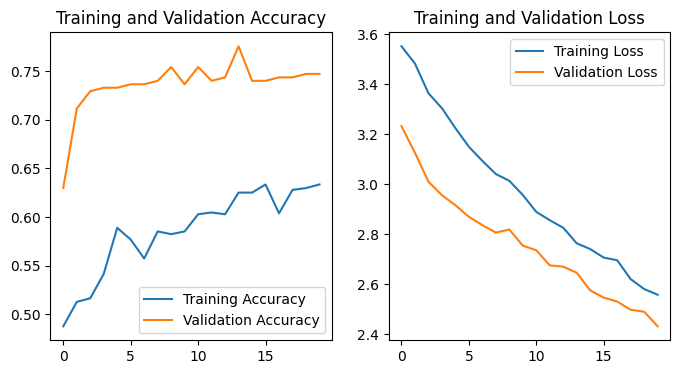

In [27]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()